In [128]:
%load_ext tensorboard

ModuleNotFoundError: No module named 'tensorboard'

In [14]:
import glob
import pandas as pd
import numpy as np

In [28]:
allFiles = glob.glob("dp/notebooks/lexicons_utf_fixed/*")
allDF = (pd.read_csv(f, dtype=str, encoding='utf-8', sep='\t', names=['grapheme', 'phoneme']) for f in allFiles)

df = pd.concat(allDF, ignore_index=True)
df.insert(0, 'lang', 'pt_br')
df['phoneme'] = df['phoneme'].str.strip()

<AxesSubplot: >

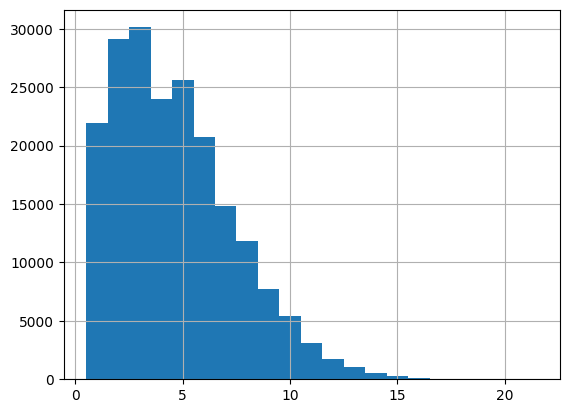

In [30]:
#tamanho de cada palavra
wordLen = df['grapheme'].apply(lambda x: [len(w) for w in x.split()])
data = pd.DataFrame( {'column':np.concatenate(wordLen.values)} )['column']
data.hist(bins=[i+0.5 for i in range(data.max()+1)])

<AxesSubplot: >

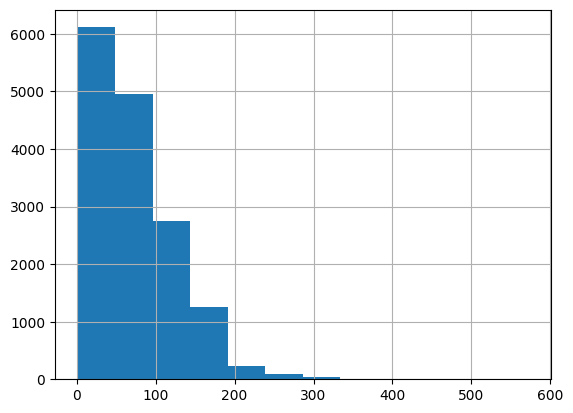

In [31]:
#número de grafemas de cada sentença
sentenceGraphemeLen = df['grapheme'].str.len()
sentenceGraphemeLen.hist(bins=12)

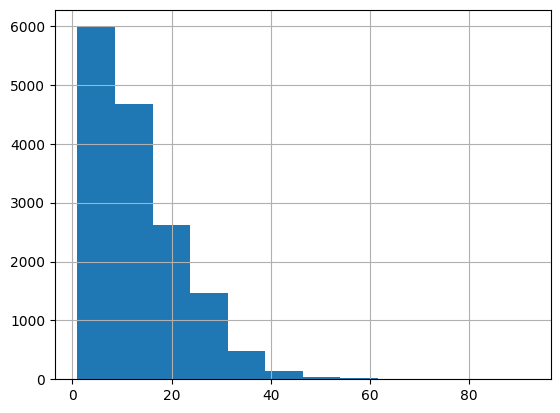

In [32]:
#número de palavras de cada sentença
sentenceWordLen = df['grapheme'].str.split().str.len().hist(bins=12)

In [33]:
df['grapheme'] = df['grapheme'].map(str)
df['phoneme'] = df['phoneme'].map(str)

# df['phoneme'] = df['phoneme'].str.replace("\\\\pau\\\\", '\\\\,\\\\')
df['phoneme'] = df['phoneme'].str.replace("a~", "ã")
df['phoneme'] = df['phoneme'].str.replace("e~", "ẽ")
df['phoneme'] = df['phoneme'].str.replace("i~", "ĩ")
df['phoneme'] = df['phoneme'].str.replace("o~", "õ")
df['phoneme'] = df['phoneme'].str.replace("O~", "Õ")
df['phoneme'] = df['phoneme'].str.replace("u~", "ũ")

In [34]:
graphemes = ''.join(sorted(list(set(df['grapheme'].sum()))))

phonemes = pd.DataFrame(
    df['phoneme'].str.split("")
        .explode().drop_duplicates()
        .sort_values().reset_index(drop=True)
        .values.tolist(), columns=['phon']
)

phonemes = phonemes['phon'].to_list()
phonemes.remove("")

In [35]:
df['gsize'] = df['grapheme'].apply(lambda x : len(x))
df['psize'] = df['phoneme'].apply(lambda x : len(x))
df = df[df['psize'] <= 300]

In [36]:
hist = df.copy()
hist.phoneme = hist.phoneme.str.len()
hist.grapheme = hist.grapheme.str.len()

<AxesSubplot: >

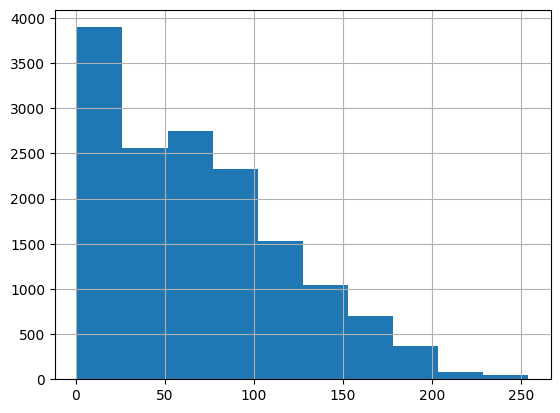

In [138]:
hist['grapheme'].hist()

<AxesSubplot: >

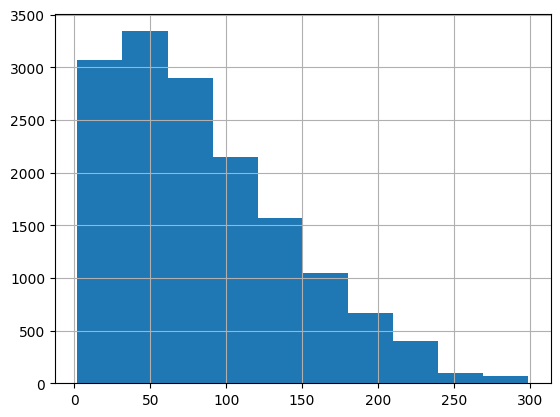

In [139]:
hist['phoneme'].hist()

In [140]:
df['gWords'] = df['grapheme'].str.count(' ') + 1
df['pWords'] = df['phoneme'].str.count(' ') + 1
df['grapheme'] = df['grapheme'].str.split(' ')
df['phoneme'] = df['phoneme'].str.split(' ')

In [142]:
df[df.gWords > df.pWords].apply(lambda x:
    x.phoneme.extend([''] * (x.gWords - x.pWords)), axis=1)
df[df.pWords > df.gWords].apply(lambda x:
    x.grapheme.extend([''] * (x.pWords - x.gWords)), axis=1)
dfWords = (df.apply(pd.Series.explode)
    .drop(['lang', 'gWords', 'pWords'], axis=1))

In [12]:
allFiles = glob.glob("dp/notebooks/lexicons/*")
allDF = (pd.read_csv(f, encoding='utf-8', sep='\t', names=['grapheme', 'phoneme']) for f in allFiles)

df = pd.concat(allDF, ignore_index=True)
df.insert(0, 'lang', 'pt_br')
df['phoneme'] = df['phoneme'].str.strip()

df['grapheme'] = df['grapheme'].map(str)
df['phoneme'] = df['phoneme'].map(str)

df['phoneme'] = df['phoneme'].str.replace("\\\\pau\\\\", '\\\\,\\\\')
df['phoneme'] = df['phoneme'].str.replace("a~", "ã")
df['phoneme'] = df['phoneme'].str.replace("e~", "ẽ")
df['phoneme'] = df['phoneme'].str.replace("i~", "ĩ")
df['phoneme'] = df['phoneme'].str.replace("o~", "õ")
df['phoneme'] = df['phoneme'].str.replace("u~", "ũ")

graphemes = ''.join(sorted(list(set(df['grapheme'].sum()))))

phonemes = pd.DataFrame(
df['phoneme'].str.split("\\")
    .explode().drop_duplicates()
    .sort_values().reset_index(drop=True)
    .values.tolist(), columns=['phon']
)

phonemes['len'] = phonemes['phon'].str.len()
phonemes['upper'] = phonemes['phon'].str.isupper()
phonemes = phonemes.sort_values(by=['len', 'upper', 'phon'], ascending=False)['phon'].values.tolist()

phonemes.append("~")
phonemes.remove(" '")
phonemes.remove("")

df['phoneme'] = df['phoneme'].str.replace('\\', '')
df['gsize'] = df['grapheme'].apply(lambda x : len(x))
df['psize'] = df['phoneme'].apply(lambda x : len(x))
df = df[df['psize'] <= 225]

dfsize = df.shape[0]

subset = df[['lang', 'grapheme', 'phoneme']]
train_data = [tuple(x) for x in subset.to_numpy()]

In [18]:
'w̃' == 'w̃'

True